In [ ]:
%pip install tensorflow tflite_runtime
%pip install matplotlib numpy pillow

In [1]:
import os
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from IPython.display import display
from matplotlib import pyplot as plt
from test_utils import *
from utils import *

2024-04-09 15:32:17.949389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 15:32:18.539661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
MODEL = './saved_models/3'
TEST = './test/test.jpg'
WIDTH = 360
HEIGHT = 640

model = load_model(MODEL, custom_objects={"psnr": inference_psnr})

In [15]:
img = cv2.imread(TEST)
target = cv2.resize(img, (1920, 1080))
img.shape

(360, 640, 3)

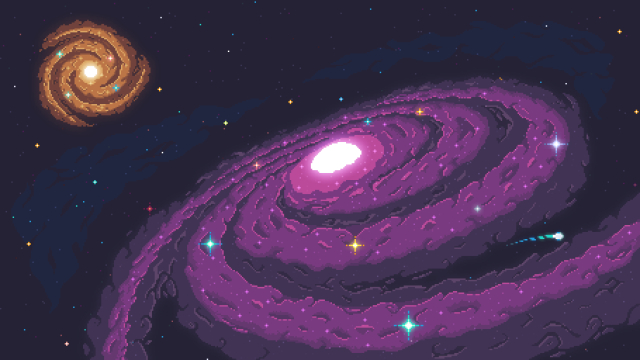

In [16]:
img2 = img[:,:,::-1]
display(Image.fromarray(img2))

In [17]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(img)
(y, cb, cr) = convert_to_yCbCr(pil_img)

In [18]:
upscaledY = model.predict(y[None, ...])[0]
finalOutput = postprocess_image(upscaledY, cb, cr)
inference = np.array(finalOutput)

1/1 [==============================] - 0s 101ms/step


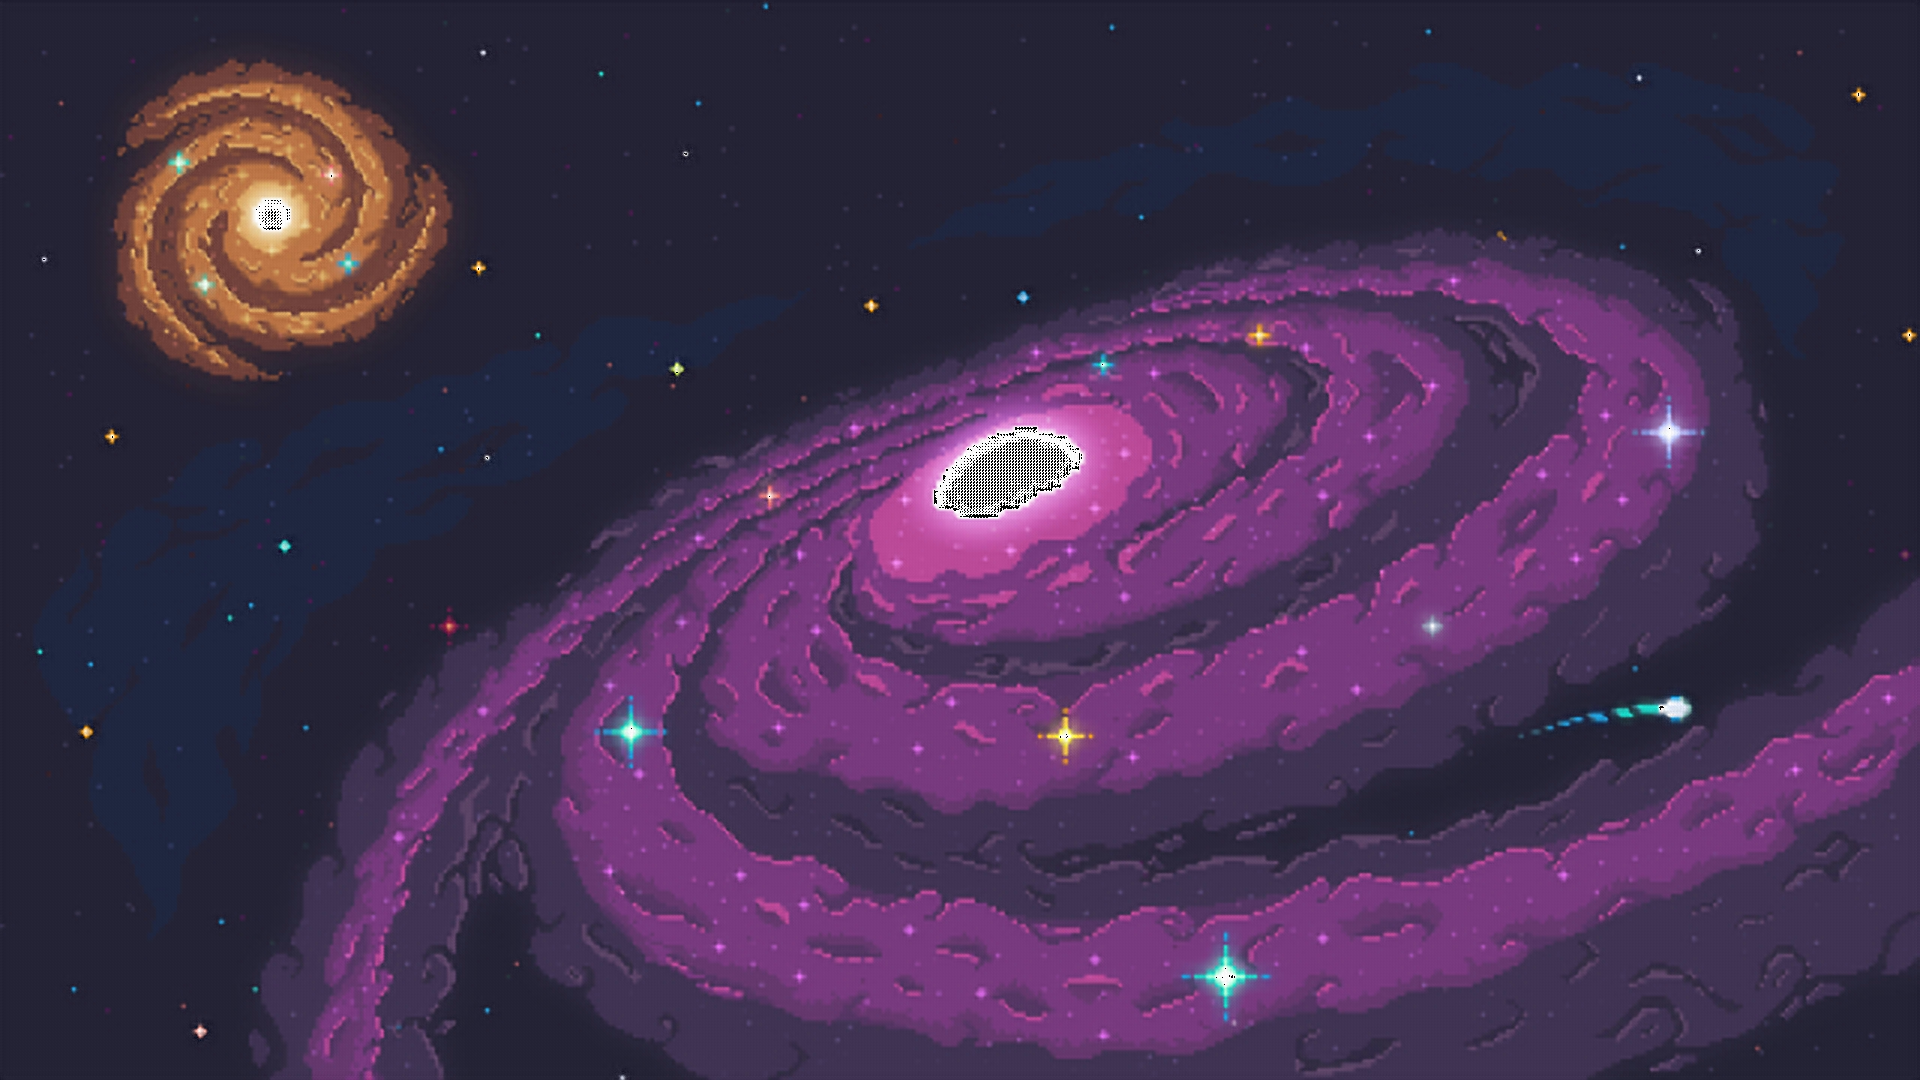

In [22]:
img2 = inference[:,:,::-1]
display(Image.fromarray(inference))

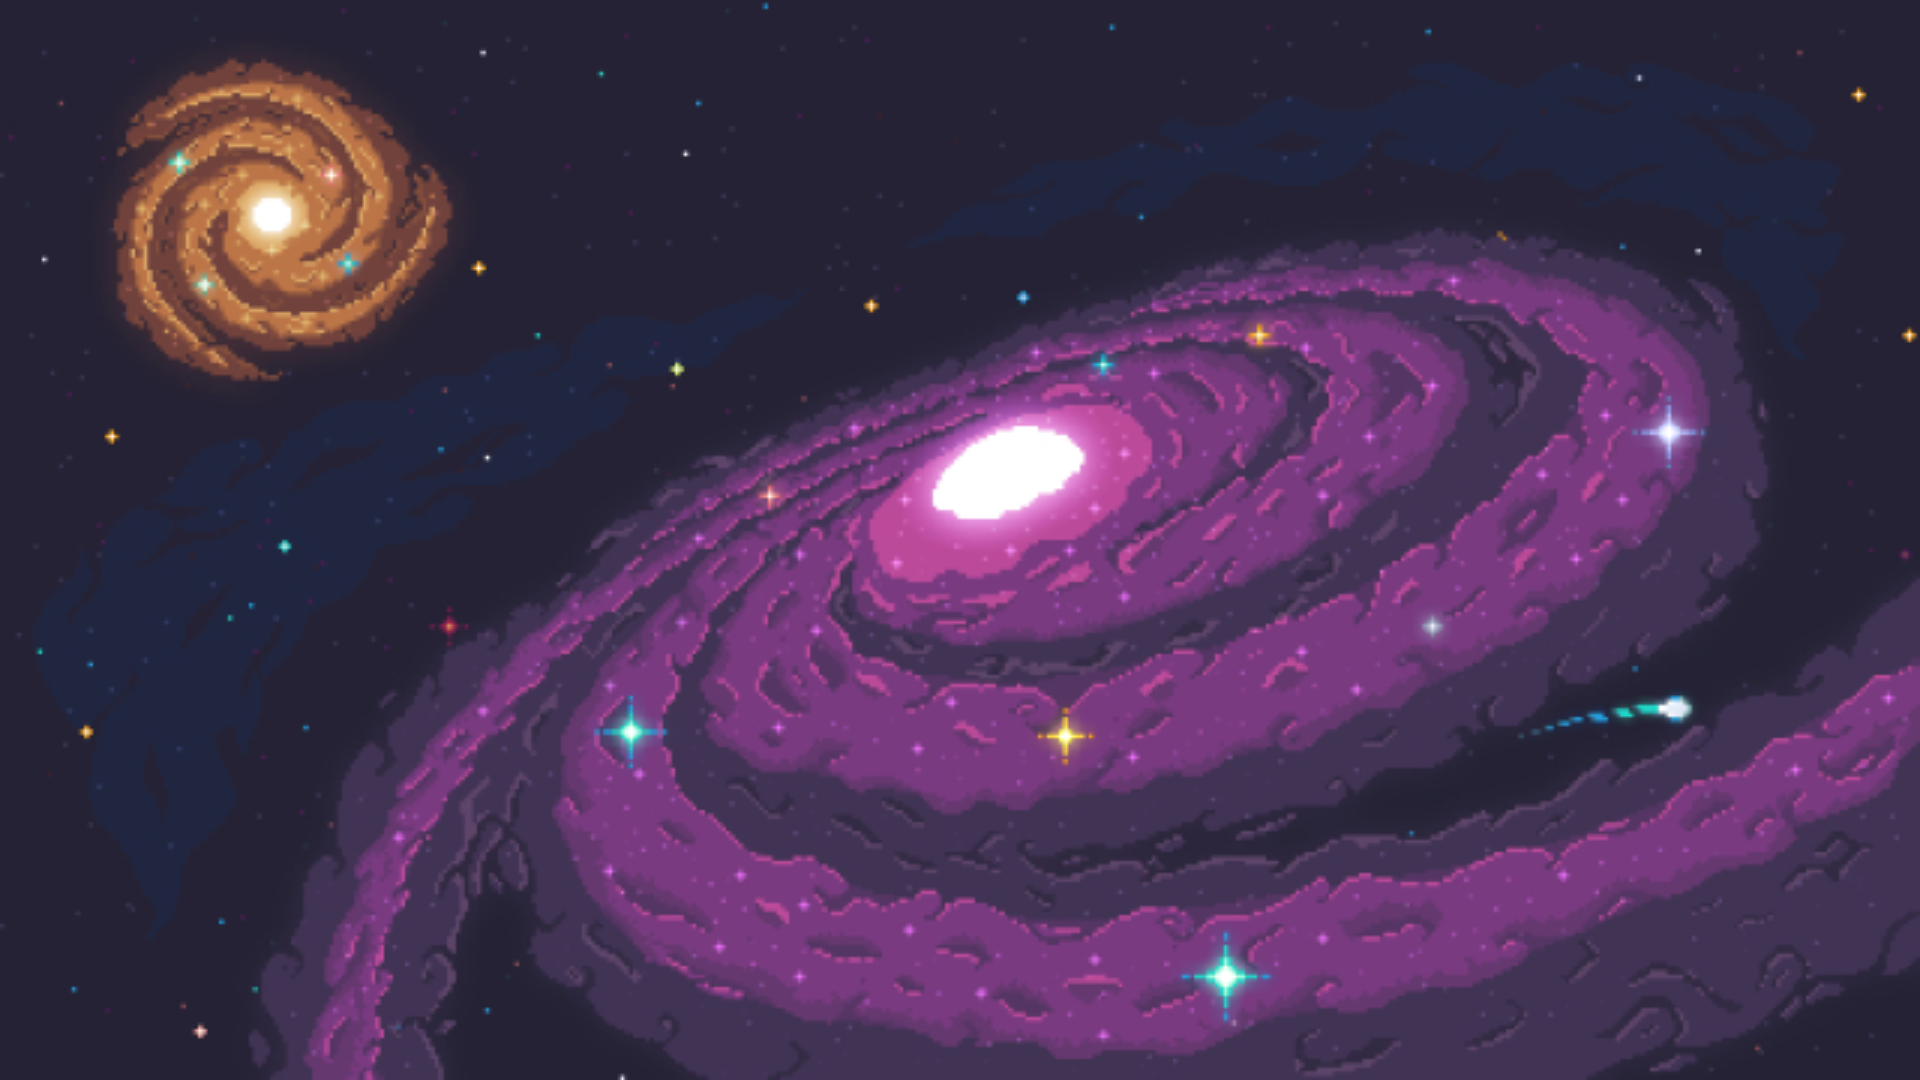

In [10]:
img2 = target[:,:,::-1]
display(Image.fromarray(img2))

In [4]:
MODEL = './saved_models/full_yuv'
TEST = './test/test.jpg'
WIDTH = 360
HEIGHT = 640

model = load_model(MODEL, custom_objects={"psnr": inference_psnr})

In [5]:
img = cv2.imread(TEST)
target = cv2.resize(img, (1920, 1080))
img.shape

(360, 640, 3)

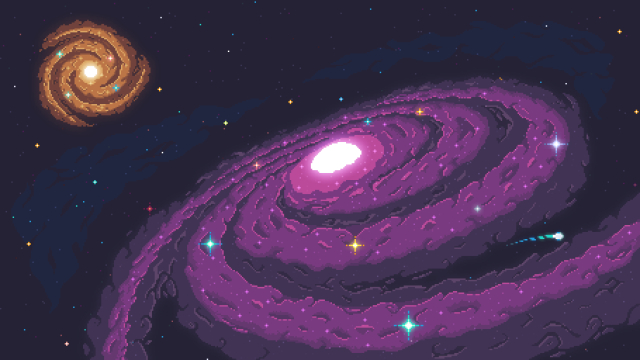

In [6]:
img2 = img[:,:,::-1]
display(Image.fromarray(img2))

In [28]:
def convert_to_yuv(image: Image):
    ycbcr = image.convert("YCbCr")
    (y, cb, cr) = ycbcr.split()

    denominator = 240. - 16.

    y = np.array(y)
    y = y.astype("float32") / 255.0

    cb = np.array(cb)
    cb = (cb.astype("float32") - 16.) / denominator

    cr = np.array(cr)
    cr = (cr.astype("float32") - 16.) / denominator

    return np.stack((y, cb, cr), axis=-1)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(img)
yuv = convert_to_yuv(pil_img)
yuv.shape

(360, 640, 3)

In [63]:
upscaled = model.predict(yuv[None, ...])[0]
Y, U, V = np.split(upscaled, 3, axis=2)

print(Y.shape)
print(U.shape)
print(V.shape)
print(upscaled.shape)

1/1 [==============================] - 0s 14ms/step


(1080, 1920, 1)
(1080, 1920, 1)
(1080, 1920, 1)
(1080, 1920, 3)


In [64]:
diff = 240 - 16
Y = (Y * 255).astype(np.int8)
U = np.array(diff * U + 16, dtype=np.int8)
V = np.array(diff * V + 16, dtype=np.int8)

print(Y.shape)
print(U.shape)
print(V.shape)

upscaled_img = np.concatenate((Y, U, V), axis=-1)
upscaled_img.shape

(1080, 1920, 1)
(1080, 1920, 1)
(1080, 1920, 1)


(1080, 1920, 3)

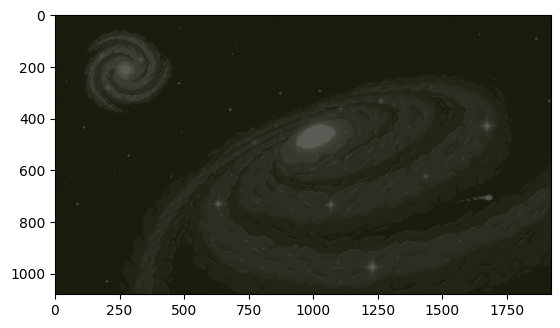

In [69]:
# display(Image.fromarray(upscaled_img))
img2 = upscaled_img[:,:,::-1]
plt.imshow(img2)

In [9]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

print(psnr(target, inference))

28.357443883922766
